## -------Import Library-------


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from skimage import data,io

from skimage.color import rgb2hsv
from scipy import ndimage, misc
from skimage.feature import hog
from skimage import data, exposure
from sklearn.cluster import KMeans

## -------Load Image-------
img: h x w x 3

skimage.io.imread

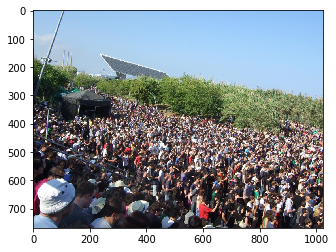

In [15]:
rgb_img = io.imread('test_img/IMG_52.jpg')
plt.imshow(rgb_img)

## -------Extract Features-------

feature_mat: h x w x n

n: number of features per pixel (depends on number of window size r)

e.g. r = range(1,50)

feature_mat = feature_extractor(img, r)

In [16]:
r = np.array([1,5]) #np.arange(10,60,10)

feature_mat = feature_extractor(rgb_img, r)


## -------Clustering-------

cluster_map: h x w (only contains 0 or 1; 0 for background; 1 for crowd)

cluster_map = kmeans(feature_mat, k=2)


In [17]:
a,b,c = feature_mat.shape
input_data = np.reshape(feature_mat, (a*b, c))

kmeans = KMeans(n_clusters=2, random_state=0).fit(input_data)
labels = kmeans.labels_

cluster_map = np.reshape(labels,(a,b))

## -------Plotting resulting image-------

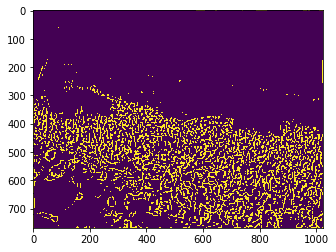

In [24]:
plt.imshow(cluster_map)
plt.savefig('Result_52.jpg')

## -------Compare with ground truth-------

# =======Utils=======

## -------Extract feature 1 (LoG)-------

feature1: h x w 


In [4]:
def rad2complex(I):
    I_tilde = np.exp(1j*I)
    return I_tilde

def angular_diff(t1, t2):
    ans = (t2-t1+np.pi) % (2*np.pi) - np.pi
    return ans

def wrap_index(U,V,w,h):
    u = U
    v = V
    if U>=h:
        u= U-h
        
    if V>=w:
        v = V-w
        
    return u,v

def LoG_I(Ih_tilde, Is, r, alpha):
    w = Is.shape[1]
    h = Is.shape[0]
    
    I_gauss_r = ndimage.gaussian_filter(np.real(Ih_tilde), sigma=1/3)
    I_gauss_i = ndimage.gaussian_filter(np.imag(Ih_tilde), sigma=1/3)
    I_gauss = I_gauss_r + 1j*I_gauss_i
    
    LoGI = np.zeros((h,w))
    for u in range(h):
        for v in range(w):
            s = 0
            for U in range(u-r, u+r+1):
                for V in range(v-r, v+r+1):
                    U_wrap,V_wrap = wrap_index(U,V,w,h)
                    s = s + angular_diff(np.angle(I_gauss[U_wrap,V_wrap]), np.angle(I_gauss[u,v])) * (Is[u,v] * Is[U_wrap,V_wrap])**alpha
                    
            LoGI[u,v] = s
            
    return LoGI

def extract_feat1(Ih, Is, r):
    alpha = 0.25
    Ih_tilde = rad2complex(Ih)
    LoGI = LoG_I(Ih_tilde, Is, r, alpha)
    feat = ndimage.gaussian_filter(LoGI, sigma=r/3)
    
    return feat

## -------Extract feature 2 (Entropy)-------

feature2: h x w

In [5]:
def B_k(b, k, Ih, u, v):
    if (2 * k * np.pi) / b <= Ih[u, v] < (2 * (k+1) * np.pi) / b:
        bk = 1
    else:
        bk = 0
    return bk


def sum_arg(b, k, Ih, r, N):
    w = Ih.shape[1]
    h = Ih.shape[0]
    Bk = np.zeros((h,w))
    for u in range(h):
        for v in range(w):
            Bk[u, v] = B_k(b, k, Ih, u, v)
    comp_1 = ndimage.gaussian_filter(Bk, sigma=r/3)
    comp_2 = np.log2(comp_1 + 1e-16)
    nominator = np.multiply(comp_1, comp_2)
    denominator = np.log2(N)
    return - nominator/denominator


def extract_feat2(Is, Ih, r, N=3):
    beta = 0.25
    b = 10
    k = 0
    comp_1 = np.zeros(sum_arg(b, k, Ih, r, N).shape)
    for k in range(b+1):
        comp_1 += sum_arg(b, k, Ih, r, N)
    comp_2 = np.power(ndimage.gaussian_filter(Is, sigma=r/3), beta)
    feat = np.multiply(comp_1, comp_2)

    return feat

## -------Extract feature 3 (HOG)-------

feature3: h x w

In [6]:
def extract_feat3(Iv,r):
    #we change the pixel per cell from 1*1 to 16*16 based on Dalal and triggs
    fd, hog_image = hog(Iv, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=False)
    w = Iv.shape[1]
    h = Iv.shape[0]
    res = np.zeros((h,w))
    for i in range(0,h,16):
        for j in range(0,w,16):
            feat = ndimage.gaussian_filter(fd[i:i+8], sigma=r/3)
            feat = np.sqrt(np.sum(feat**2))
            if(i + 16 <h and j + 16<w):
                   temp = np.zeros([16,16])
                   temp.fill(feat)
                   res[i:i+16,j:j+16] = temp
            elif(i + 16 >= h and j + 16 < w):
                   temp = np.zeros([h-i,16])
                   temp.fill(feat)
                   res[i:h,j:j+16] = temp
            elif(i + 16 < h and j + 16 >= w):
                   temp = np.zeros([16,w-j])
                   temp.fill(feat)
                   res[i:i+16,j:w] = temp
            elif(i + 16 >= h and j + 16 >= w):
                   temp = np.zeros([h-i,w-j])
                   temp.fill(feat)
                   res[i:h,j:w] = temp
    return res

## -------Feature Extractor-------

In [7]:
def feature_extractor(img, r):
        """ img: h x w x 3
           r: m dimensional vector
           feature_mat: h x w x 3m
        """
        m = np.size(r)
        h = img.shape[0]
        w = img.shape[1]

        ## Convert to HSV 
        # img_HSV: h x w x 3
        hsv_img = rgb2hsv(img)

        hue_img = hsv_img[:, :, 0]
        sat_img = hsv_img[:, :, 1]
        value_img = hsv_img[:, :, 2]
        
        feature1 = np.zeros((h,w,m))
        feature2 = np.zeros((h,w,m))
        feature3 = np.zeros((h,w,m))
        
        feature_mat = []

        for i in range(np.size(r)):
            
            feature1[:,:,i] = extract_feat1(hue_img, sat_img, r[i])
            
            feature2[:,:,i] = extract_feat2(sat_img, hue_img,r[i],N=3)
            
            feature3[:,:,i] = extract_feat3(value_img,r[i])
            
        feature_mat = np.concatenate((feature1, feature2, feature3), axis=2) 

        return feature_mat